### Multi-model DP using Advantage function

In [1]:
import torch
import numpy as np
import sys
sys.path.append('../')
from robust_tt import RTT
from dyn_models.dynamic_systems_mm import Reorientation3
import numpy as np
from tt_utils import contract_sites, get_prob_x

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

dt=0.01
T = 10

state_max = torch.tensor([1.1*torch.pi,5*torch.pi]).to(device) # (theta,dtheta)
state_min = torch.tensor([0,0]).to(device)
# state_max = torch.tensor([1.1*torch.pi,4*torch.pi]).to(device) # (theta,dtheta)
# state_min = -1*state_max

n_state = 50
n_param = 100
n_action = 50

mass = 1.0; length=0.5; g= 9.81; coef_viscous = 0.1

dtheta_init = torch.tensor([torch.pi*2]).to(device) # Initial angular velocity given by hand

param_min = torch.tensor([0.2, 0.15, 0.2]).to(device) # mass, length, torsional friction coefficient
param_max = torch.tensor([1.0, 0.4, 1.0]).to(device)
action_max = 4*mass*g*length 
action_max = torch.tensor([action_max]).to(device) # normal force
action_min = torch.tensor([0]).to(device)

In [4]:
domain_state = [torch.linspace(state_min[i],state_max[i],n_state).to(device) for i in range(len(state_max))]
domain_param = [torch.linspace(param_min[i],param_max[i],n_param).to(device) for i in range(3)]
domain_state_param = domain_state + domain_param

domain_action = [torch.linspace(action_min[i],action_max[i],n_action).to(device) for i in range(len(action_max))]
domain_state_action  = domain_state + domain_action

In [5]:
w_goal=1.0
w_action=0.01
w_scale = 1
sys = Reorientation3(state_min=state_min, state_max=state_max, action_max=action_max, action_min=action_min, dt=dt, w_scale=w_scale, w_goal=w_goal, w_action=w_action, device=device)



In [6]:
def forward_model(state_param,action):
    return sys.forward_simulate(state_param,action)

def reward(state_param,action):
    rewards = sys.reward_state_action(state_param,action)
    return rewards



In [7]:
n_test = 100
dim_state = len(domain_state)
init_state = torch.zeros((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.0,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)
# state[:, 0] = torch.rand(n_test).to(device)*(state_max[0])
state[0, 0] = torch.zeros_like(state[0, 0])
state[:, 1] = torch.ones_like(state[:, 1])*(state_max[1])


In [8]:
rtt = RTT(domain_state=domain_state_param, domain_action=domain_action, domain_param=domain_param, reward=reward, 
                forward_model=forward_model, gamma=0.999, n_steps=1,
                rmax_v=100, rmax_a=100, nswp_v=10, nswp_a=10, 
                kickrank_v=10, kickrank_a=10,
                max_batch_v=10**4,max_batch_a=10**5,
                eps_cross_v=1e-3, 
                eps_cross_a=1e-3,
                eps_round_v=1e-3, 
                eps_round_a=1e-3, 
                n_samples=1, normalize_reward=False,
                verbose=True,
                device=device) # action = 'deterministic_tt', 'stochastic_tt', 'random'

In [9]:
model = torch.load('tt_models/reorientation.pt')
rtt.reward_tt = model['reward_tt'].to(rtt.device)
rtt.reward_max = rtt.get_max_a(rtt.reward_tt)[0]
if not rtt.normalize_reward:
    rtt.reward_max = 1.0
else:
    rtt.reward_max = torch.abs(rtt.get_max_a(rtt.reward_tt)[0])
rtt.reward_normalized_tt = rtt.reward_tt*(1/rtt.reward_max)
rtt.reward_normalized_tt.round(1e-9)
rtt.reward_normalized_tt = rtt.reward_normalized_tt.to(rtt.device)  
rtt.v_model = model['v_model'].to(rtt.device)
rtt.a_model = rtt.compute_advantage_model_from_value().to(rtt.device)
rtt.policy_model = rtt.normalize_tt_a(rtt.a_model.clone())
rtt.policy_model_cores = rtt.policy_model.tt().cores[:]


.....................................................
Computing Advantage Fcn
.....................................................
cross device is cuda
Cross-approximation over a 6D domain containing 1.25e+11 grid points:
iter: 0  | eps: 3.433e-01 | time:   0.0561 | largest rank:   1
iter: 1  | eps: 1.435e-01 | time:   0.1322 | largest rank:  11
iter: 2  | eps: 4.477e-02 | time:   0.2453 | largest rank:  21
iter: 3  | eps: 2.641e-02 | time:   0.4823 | largest rank:  31
iter: 4  | eps: 1.045e-02 | time:   0.8329 | largest rank:  41
iter: 5  | eps: 5.914e-03 | time:   1.3099 | largest rank:  51
iter: 6  | eps: 3.745e-03 | time:   1.9392 | largest rank:  61
iter: 7  | eps: 2.914e-03 | time:   2.9395 | largest rank:  71
iter: 8  | eps: 2.412e-03 | time:   4.0389 | largest rank:  81
iter: 9  

| eps: 1.582e-03 | time:   5.6120 | largest rank:  91 <- max_iter was reached: 10
Did 18103750 function evaluations, which took 3.64s (4.973e+06 evals/s)



In [10]:
def contract_callback(rtt, state, policy_model, real_param, T=10,  animation=False):   
    print("Testing....")

    traj = state.clone().view(1,-1,2) # time x sample x 2
    T=int(T/dt)
    cum_reward = torch.tensor([0.]*state.shape[0]).to(device)
    real_state_param = torch.cat((state,real_param),dim=-1)   
    segment = 1
    for _ in range(int(T/segment)):
        state = real_state_param[:,:2]
        action = rtt.policy_ttgo_contract(state, policy_model, device)
        r = rtt.reward_normalized(real_state_param,action)#reward_test(state,action)
        cum_reward+=r
        real_state_param = forward_model(real_state_param,action)

        traj = torch.concat((traj,real_state_param[:,:2].view(1,-1,2)),dim=0)
    # final_state = traj[-1, :, :2]
    # final_err = (final_state[:,0].abs()-torch.pi).abs()
    # print('final state:', final_state[:, 0])

    # print('Average reward:', cum_reward.mean())
    # print('Final error:', final_err.mean())

    theta_t = traj[:,0,0] #torch.atan2(traj[:,1],traj[:,0])
    from plot_utils import plt_pendulum
    plt=plt_pendulum(theta_t.to('cpu').numpy(), figsize=5, dt=dt, scale=10, skip=10, animation=animation, name='average_advantage.mp4')
    plt.show()
    

Testing....


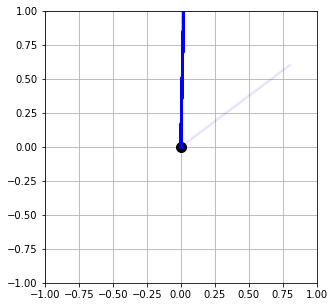

In [11]:
site_x = [2, 3, 4]
num_para = len(site_x)

# state initialization
init_state = torch.zeros((n_test,dim_state))
for i in range(dim_state):
    init_state[:,i] = state_min[i] + torch.rand(n_test).clip(0.0,0.75).to(device)*(state_max[i]-state_min[i])
state = init_state.to(device)
state[:, 0] = torch.rand(n_test).to(device)*(state_max[0])
state[:, 1] = torch.ones_like(state[:, 1])*(state_max[1]) # maximum dtheta as initial angular velocity

# param initialization
mean_id = torch.randint(0, n_param-1, (num_para,)).to(device)
real_param = torch.zeros(num_para).to(device)
for i in range(num_para):
    real_param[i] = domain_param[i][mean_id[i]]
real_param = real_param.view(1, -1).expand(n_test, -1).to(device)

# get parameter-conditioned advantage function through domain contraction
rtt.domain_state_action = domain_state + domain_action # the previous domain_state_action is domain_state + domain_param + domain_action
contract_policy_model = rtt.get_contract_policy(site_x=site_x, mean_id=mean_id, sigma=n_param, length=1/5*n_param, flag = 'uniform', device=device)

contract_callback(rtt, state, contract_policy_model, real_param, T=T,  animation=False)